## Regularization: application with medical microbiology diagnosis

We want to predict the IBD (Inflammatory Bowel Disease) clinical status of patients **given the abundance of microbial species** living in their gut.

Each patient is assigned to a clinical status, and the abundances of known species in their gut are reported in a matrix of size `patient x species`.

We focus here on the seminal metagenomic study by Nielsen H.B. et al, published in 2014.



In [3]:
import pandas as pd
import numpy as np
from sklearn import linear_model
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate
from sklearn.metrics import roc_auc_score

# Viz
import matplotlib.pyplot as plt

In [5]:
# Load the data
ab_data_pd = pd.read_csv("gut_abundances.tsv", sep="\t", header = 0)
descriptor_names = ab_data_pd.columns
ab_data = ab_data_pd.to_numpy()
status_txt =  pd.read_csv("ibd_status.lst", sep="\t", header = None).to_numpy()
ab_data_pd

,k__Bacteria,k__Archaea,k__Viruses,k__Bacteria|p__Bacteroidetes,k__Bacteria|p__Firmicutes,k__Bacteria|p__Proteobacteria,k__Bacteria|p__Actinobacteria,k__Archaea|p__Euryarchaeota,k__Bacteria|p__Verrucomicrobia,k__Viruses|p__Viruses_noname,...,k__Bacteria|p__Proteobacteria|c__Alphaproteobacteria|o__Rhodobacterales|f__Rhodobacteraceae,k__Viroids|p__Viroids_noname|c__Viroids_noname|o__Viroids_noname|f__Pospiviroidae|g__Pospiviroidae_noname,k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Actinomycetales|f__Microbacteriaceae|g__Leifsonia,k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Chromatiales|f__Ectothiorhodospiraceae|g__Thioalkalivibrio,k__Bacteria|p__Proteobacteria|c__Alphaproteobacteria|o__Rhodobacterales|f__Rhodobacteraceae|g__Labrenzia,k__Viroids|p__Viroids_noname|c__Viroids_noname|o__Viroids_noname|f__Pospiviroidae|g__Pospiviroidae_noname|s__Dahlia_latent_viroid,k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Actinomycetales|f__Microbacteriaceae|g__Leifsonia|s__Leifsonia_unclassified,k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Chromatiales|f__Ectothiorhodospiraceae|g__Thioalkalivibrio|s__Thioalkalivibrio_unclassified,k__Bacteria|p__Proteobacteria|c__Alphaproteobacteria|o__Rhodobacterales|f__Rhodobacteraceae|g__Labrenzia|s__Labrenzia_unclassified,k__Viroids|p__Viroids_noname|c__Viroids_noname|o__Viroids_noname|f__Pospiviroidae|g__Pospiviroidae_noname|s__Dahlia_latent_viroid|t__PRJNA186953
MH0001,99.85542,0.12024,0.02435,75.76233,22.45185,0.79821,0.77138,0.12024,0.04902,0.02435,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
MH0002,99.84094,0.00000,0.15906,29.66601,63.00964,0.80546,1.31857,0.00000,5.02320,0.15906,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
MH0003,99.99769,0.00000,0.00231,28.89089,68.87499,1.10182,1.11216,0.00000,0.00000,0.00231,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
MH0004,99.54958,0.44427,0.00615,36.82369,59.90264,0.96707,1.79713,0.44427,0.00000,0.00615,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
MH0005,99.85338,0.02338,0.12324,53.45066,44.00230,0.66402,1.34265,0.02338,0.33886,0.12324,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
V1_UC61_0,100.00000,0.00000,0.00000,73.60036,23.13241,1.97125,1.29598,0.00000,0.00000,0.00000,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
V1_UC62_0,99.43677,0.53534,0.02789,59.81443,31.16507,1.25950,7.12218,0.53534,0.07560,0.02789,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
V1_UC7_0,99.97056,0.00000,0.02944,61.47615,31.97288,3.65580,1.59657,0.00000,1.25953,0.02944,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
V1_UC8_0,96.71485,3.21396,0.01313,26.64142,56.61496,0.68027,7.95935,3.21396,4.79898,0.01313,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000


Take a look at the data: number of samples ($n$), number of descriptors ($p$), names of descriptors (in ```descriptor_names```), etc.

In [8]:
n,p = ab_data.shape
print("Data shape:",n,p)

Data shape: 396 1939


We now transform the target variable to a binary (0 ==  control, 1 == IBD) variable ```status```:

In [10]:
status = np.ravel([int(s == "IBD") for s in status_txt])
status

C:\Users\ilyin\AppData\Local\Temp\ipykernel_9860\110993762.py:1: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  status = np.ravel([int(s == "IBD") for s in status_txt])


array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1,
       1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0,

What is the name of the most correlated species (we denote by S) to the clinical status? Use the ```np.corrcoef``` function to compute the correlation between the data and the status.
You can compute the correlation between the data and the status using ```corr_vector = np.corrcoef(ab_data.transpose(),status))[:-1,p]```, which gives the correlation for each species.

In [29]:
#TO COMPLETE
corr_vector = np.corrcoef(ab_data.T,status)[:-1,p]
i_max = np.argmax(corr_vector)
ab_data_pd.columns[i_max]

'k__Bacteria|p__Bacteroidetes|c__Bacteroidia|o__Bacteroidales|f__Prevotellaceae|g__Prevotella|s__Prevotella_oris'

Create a (naïve) predictor that takes as input the abundance of S and output the clinical status of the patient. Either compute the prediction accuracy or its AUC ROC for every threshold, this will be our baseline predictor to improve on.

(316, 1939)
(396, 1939)
Best correlated species index: 6


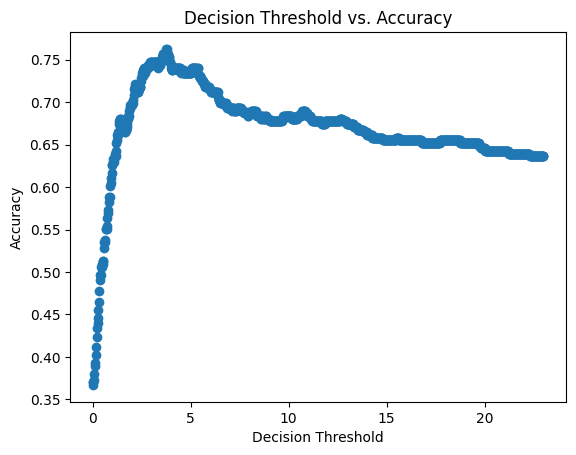

Accuracy on test set: 0.7125
AUC ROC on test set: 0.731785944551902


In [27]:
# Split data into 50% train and 50% test subsets
x_train, x_test, y_train, y_test = train_test_split(
    ab_data, status, test_size=0.2, shuffle=True
)
print(x_train.shape)
print(ab_data.shape)

# We remove species not abundant in the train set
col_to_rm = np.where(np.sum(x_train, axis=0) == 0)
x_train = np.delete(x_train, col_to_rm, axis=1)
x_test = np.delete(x_test, col_to_rm, axis=1)
n, p = x_train.shape

# Index of the best correlated species to patient's status
best_cor_sp = np.argmax(np.abs(np.corrcoef(x_train.T, y_train)[p, :-1]))
print("Best correlated species index:", best_cor_sp)

# Compute accuracy
accuracy = list()
ths = np.linspace(0, int(np.max(x_train[:, best_cor_sp])) + 1, 1000)  # threshold list
for t in ths:
    predictions = (x_train[:, best_cor_sp] > t)
    accuracy.append(sum(predictions == y_train) / n)

# Plot the decision threshold vs. performance of the predictor
plt.scatter(ths, accuracy)
plt.xlabel('Decision Threshold')
plt.ylabel('Accuracy')
plt.title('Decision Threshold vs. Accuracy')
plt.show()

# "Real" accuracy on the test set
# Decision threshold corresponding to the best accuracy.
best_ths = ths[np.argmax(accuracy)]
# Report the accuracy on the test set
test_predictions = (x_test[:, best_cor_sp] > best_ths)
test_accuracy = sum(test_predictions == y_test) / len(y_test)
print("Accuracy on test set:", test_accuracy)

roc = roc_auc_score(y_test == 1, x_test[:, best_cor_sp])
print("AUC ROC on test set:", roc)


Now we hope that we can do better when using more than 1 descriptor.

We will first use a standard [logistic regression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html). Use the [`cross_validate`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_validate.html ) function of Sklearn to evaluate your predictor in a cross-validation way.

Take a look at what metrics you can find in the attributes of the cross-validation object `cv` and print the average accuracy.

Do you gain in terms of accuracy compared to a single predictor? Check if you are overfitting the data.

In [39]:
logreg = linear_model.LogisticRegression(solver="liblinear")
cv = cross_validate(logreg, x_train, y_train, cv=5, scoring='accuracy', return_train_score=False)


test_score = np.mean(cv['test_score'])
print("Average Cross-Validation accuracy on test:",test_score)


# Split data into 50% train and 50% test subsets
x_train, x_test, y_train, y_test = train_test_split(
    ab_data, status, test_size=0.5, shuffle=True
)

# Print example accuracy on 1 fold
fold_example = cross_validate(logreg, x_train, y_train, cv=5, scoring='accuracy', return_train_score=False)
print("Accuracy on the first fold:", np.mean(fold_example['test_score']))

 

Average Cross-Validation accuracy on test: 0.7170512820512821
Accuracy on the first fold: 0.7928205128205128


Check the `coef_` attribute of your model. How many species are you using for taking the decision?

In [44]:
# we have to use fit(), othervise coef_ does not exist
logreg.fit(x_train, y_train)

used_descriptors = np.sum(logreg.coef_ != 0)
print("The model uses", used_descriptors, "descriptors")


The model uses 1651 descriptors


Considering that only few bacterial species may be responsible for IBD, choose a relevant regularization (see the available penalties for logistic regression [here](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html)).



In [45]:
# Split data into 50% train and 50% test subsets
x_train, x_test, y_train, y_test = train_test_split(
    ab_data, status, test_size=0.5, shuffle=True
)

# Create a regularized model
logreg_regul = linear_model.LogisticRegression(penalty='l1', solver="liblinear")
logreg_regul.fit(x_train,y_train)
pred = logreg_regul.predict(x_test)

# Report accuracy on test set
test_score = np.mean(cv['test_score'])
print("Average Cross-Validation accuracy on test:",test_score)
 

Average Cross-Validation accuracy on test: 0.7170512820512821


Have you increased the accuracy? Looking at `logreg_regul.coef_`, how many descriptors are you using after regularization?
All things considered, is it a better model?

ANSwER: Yes, the model is better as we reach the same accuracy using less descriptors


In [46]:
# we have to use fit(), othervise coef_ does not exist
logreg.fit(x_train, y_train)

used_descriptors = np.sum(logreg_regul.coef_ != 0)
print("The model uses", used_descriptors, "descriptors")


The model uses 117 descriptors


Remember that equivalent accuracy, but with fewer descriptors => more robust and explainable => better model !

Find the optimal regularization strength, by comparing performances on test set and train set. If you have more time, best is to do it by plotting the mean performance in cross-validation, with confidence enveloppe (+/- std deviation) over the folds.


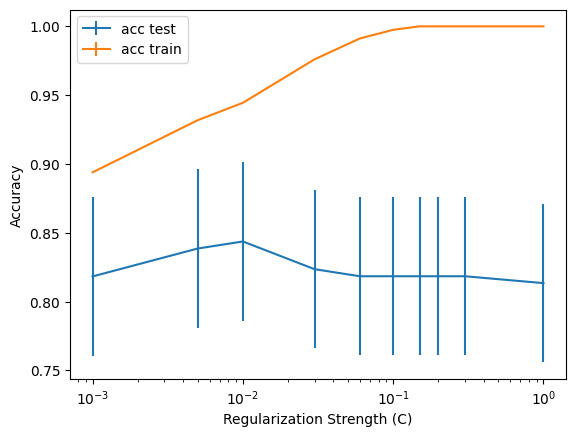

In [47]:
# Split data into 50% train and 50% test subsets
x_train, x_test, y_train, y_test = train_test_split(
    ab_data, status, test_size=0.5, shuffle=True
)

acc_test = list()
acc_train = list()

reg_strengths = [0.001, 0.005, 0.01, 0.03, 0.06, 0.1, 0.15, 0.2, 0.3, 1]



for c in reg_strengths:
    logreg = linear_model.LogisticRegression(C=c, solver="liblinear")
    cv = cross_validate(logreg, x_train, y_train, cv=5, scoring='accuracy', return_train_score=True)
    
    acc_test.append(np.mean(cv['test_score']))
    acc_train.append(np.mean(cv['train_score']))

plt.clf()
plt.errorbar(reg_strengths, acc_test, yerr=np.std(cv['test_score']), label='acc test')
plt.errorbar(reg_strengths, acc_train, yerr=np.std(cv['train_score']), label='acc train')
plt.xscale('log')
plt.xlabel('Regularization Strength (C)')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


Train a classifier on the full dataset with the optimial regularization strength, and interpret the coefficients. You can check in particular if it is consistent with [this paper](https://pubmed.ncbi.nlm.nih.gov/27999802/) and [this one](https://pubmed.ncbi.nlm.nih.gov/20648002/).

In [66]:
# c is the optimal penalty given the previous graph (hard-code this number)
c = 0.01
logreg = linear_model.LogisticRegression(C=c, solver="liblinear")
logreg.fit(ab_data,status)

# positive association IBD, you can make use of numpy argsort function
order = np.argsort(logreg.coef_)
order = order.tolist()
print(np.array(descriptor_names)[order[0][0:3]])


# negative association with IBD
order_neg = np.argsort(logreg.coef_)[0][::-1]
print(np.array(descriptor_names)[order_neg[0:3]])

order_neg

['k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Lachnospiraceae|g__Roseburia'
 'k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Lachnospiraceae|g__Blautia|s__Ruminococcus_torques'
 'k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Lachnospiraceae|g__Blautia|s__Ruminococcus_torques|t__Ruminococcus_torques_unclassified']
['k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Lachnospiraceae|g__Coprococcus|s__Coprococcus_comes'
 'k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Lachnospiraceae|g__Coprococcus|s__Coprococcus_comes|t__GCF_000155875'
 'k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Lachnospiraceae|g__Lachnospiraceae_noname|s__Lachnospiraceae_bacterium_1_1_57FAA|t__GCF_000218445']


array([164, 265, 311, ..., 262, 160, 100], dtype=int64)

## Optional: other classifiers

Use other models for supervised classification (decision trees, SVM, neural nets, etc.) with the IBD data. Evaluate properly the performances, and pay attention to regularization!

